In [1]:
from matplotlib import pyplot as plt
from torchsig.datasets.modulations import ModulationsDataset
from torchsig.datasets import conf
from typing import List, Dict
import os
import numpy as np
from torch.utils.data import DataLoader
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer
import pickle


In [2]:

class SignalGenerator:
    def __init__(self, num_samples: int, classes: List[str], num_iq_samples: int = 1_000_000, use_class_idx: bool = True,path: str ="./",file_name="generated_signals.pkl"):
        self.num_samples = num_samples
        self.classes = classes
        self.impaired = False
        self.level = 0
        self.num_iq_samples = num_iq_samples
        self.use_class_idx = use_class_idx
        self.path = path
        self.file_name = file_name

        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}

        self.config = self._select_config()
        self.dataset = self._create_dataset()

    def _select_config(self):
        config_class = conf.Sig53CleanTrainConfig
        return config_class(
            name="{}_signal_generation".format("clean"),
            num_samples=self.num_samples,
            level=self.level,
            num_iq_samples=self.num_iq_samples,
            use_class_idx=self.use_class_idx,
        )

    def _create_dataset(self):
        return ModulationsDataset(
            level=self.level,
            classes=self.classes,
            num_samples=self.num_samples,
            num_iq_samples=self.num_iq_samples,
            use_class_idx=self.use_class_idx,
            include_snr=False,
            eb_no=self.config.eb_no,
        )

    def generate(self):
        signals = []
        for idx in range(self.num_samples):
            data, label = self.dataset[idx]
            data = data.astype(np.complex64)
            signal_info={
                "data": data,
                "label_index": label,
                "label_class": self.idx_to_class[label],
            }
            signals.append(signal_info)

        self.save_iq_file(signals)

        return signals

    def save_iq_file(self, signals):
        if not os.path.exists(self.path):
            os.makedirs(self.path, exist_ok=True)

        file_path = os.path.join(self.path, self.file_name)
        with open (file_path, "wb") as f:
            pickle.dump(signals, f)


    def retrieve_signal(self, idx):
        data, label = self.dataset[idx]
        data = data.astype(np.complex64)
        return {
            "data": data,
            "class_index": label,
            "class_name": self.idx_to_class[label],
        }

In [6]:
classes=["ofdm-512"]

signal_generator = SignalGenerator(
    num_samples=len(classes),
    classes=classes,
)

generated_signals = signal_generator.generate()
sample_signal = signal_generator.retrieve_signal(0)

print("Generated Signals: ", len(generated_signals))
print("Sample Signal Info: ", sample_signal)
print("Sample Signal Data Type: ", sample_signal["data"].dtype)

Generated Signals:  1
Sample Signal Info:  {'data': array([ 0.2066821 -0.06825772j,  0.0426952 -0.07229375j,
       -0.00719543+0.00401166j, ...,  0.0379319 +0.04397516j,
        0.13519199+0.0779865j ,  0.23654696+0.03248761j], dtype=complex64), 'class_index': 0, 'class_name': 'ofdm-512'}
Sample Signal Data Type:  complex64


In [ ]:
# a method is save_iq_file(path) Done

# number o IQ samples ~ 1Million ##Done-by_default -- could be changed
# Save the dataset: a list of long signals, each signal is a numpy np.complex64 array. #Done
# File torchsig_signlas.pkl ##Done
# Insithe pkl: ##Done
# dictionary: ##Done
# d["dataset"] = list os numpy arrays
# d["num_classes"] = int
# d[classes_list] = ["bpsk", "qpsk", ...]


## collect all parameters for all kinds of classes included,, show them to Anxo, then add the needed as part of the dictionary


# Inside repo demo-spectrum-awareness:

# class Multiclass_Signal_Generator(): General class
# It has several subclasses:
# One subclass would read the signals from the PKLUse to import the signals from the pkl file (Mutaz)
# Other subclasses will just generate the signals itslefl with numpy and scipy.. (Ivana's).
# Method: generate_signals() # for pkl will import the signals from the file

class General_Multiclass_Signal_Generator():
  def __init__(self) -> None:
    self.buffer = []
    pass

  def generate_signals(self,):
    pass

  def get_signal(self, number:int=0):
    return self.buffer[number]



class PKL_File_Signal_Reader(General_Multiclass_Signal_Generator):
  def __init__(self, path):
    # Read PKL file and save in buffer

# Make tests with TDD

In [ ]:
# In repository of demo-... bracnch feature/tx-demo
# create a new file new_general_tx.py based on new_tx.py
# You need to develope a new class: General_Loop_Transmitter in a separate file
# This weill receive as arguemnt the PKL_FIle_Signal_Reader
# and inside new_general_tx will use the General_Loop_Transmitter and the PKL_File_Signal_Reader


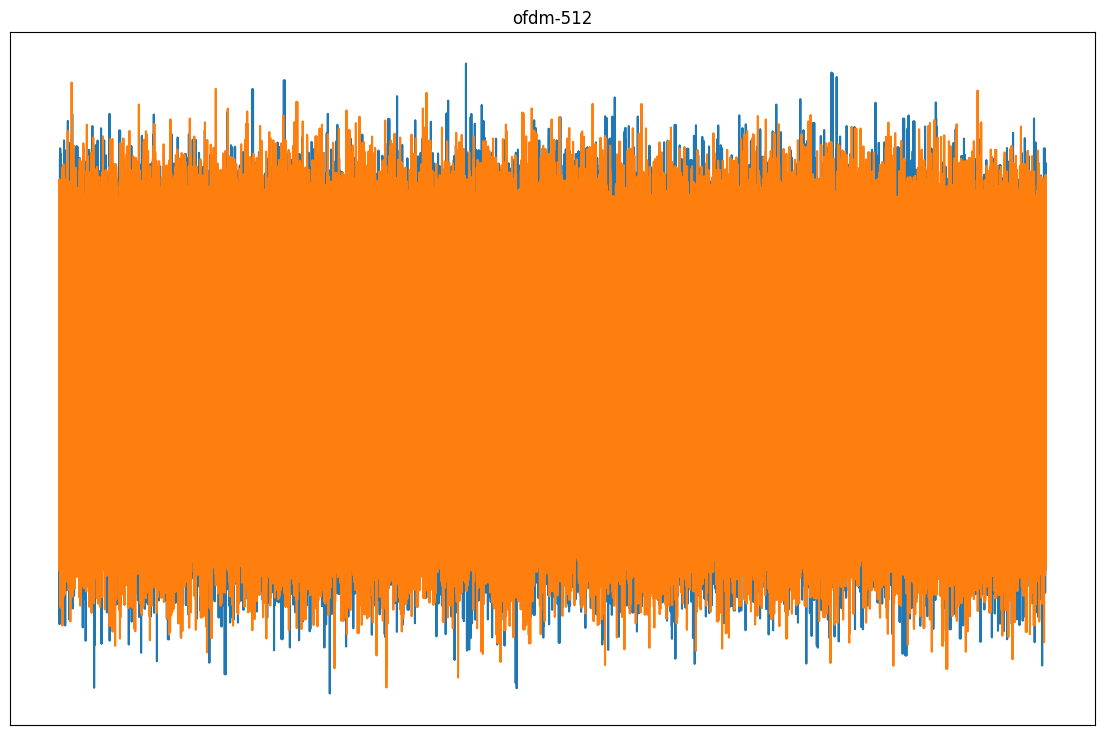

In [7]:
class DataWrapper(SignalDataset):
    def __init__(self, dataset):
        self.dataset = dataset
        super().__init__(dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        return data

    def __len__(self) -> int:
        return len(self.dataset)

plot_dataset = DataWrapper(signal_generator.dataset)

data_loader = DataLoader(dataset=plot_dataset, batch_size=16, shuffle=False)

def target_idx_to_name(tensor: np.ndarray) -> List[str]:
    batch_size = tensor.shape[0]
    label = []
    for idx in range(batch_size):
        label.append(signal_generator.idx_to_class[int(tensor[idx])])
    return label

visualizer = IQVisualizer(
    data_loader=data_loader,
    visualize_transform=None,
    visualize_target_transform=target_idx_to_name,
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break